In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
words = open('brands_list.txt', 'r').read().splitlines()
words[:10]

['PINKO',
 'DSQUARED2',
 'TAGLIATORE',
 'WOOYOUNGMI',
 'MOSCHINO',
 "MARC O'POLO",
 'GIABORGHINI',
 'SANTONI',
 'Frette',
 'RALPH LAUREN KIDS']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}
vocab_size = len(stoi)
print(len(stoi))


65


In [4]:
block_size = 3

def build_set(words):
    X= []
    Y = []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = len(words)*0.8
n2 = len(words)*0.9

Xtr,Ytr = build_set(words[:int(n1)])
X_cv , Y_cv = build_set(words[int(n1):int(n2)])
Xts,Yts = build_set(words[int(n2):])
Xtr.shape, Yts.shape, X_cv.shape, Y_cv.shape, Xts.shape, Yts.shape



(torch.Size([2333, 3]),
 torch.Size([288]),
 torch.Size([252, 3]),
 torch.Size([252]),
 torch.Size([288, 3]),
 torch.Size([288]))

In [5]:
n_emb = 4
n_hidden = 100

# https://pytorch.org/docs/stable/nn.init.html

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size , n_emb) , generator=g)
W1 = torch.randn((n_emb*block_size , n_hidden) , generator=g) * (5/3)/(n_emb*block_size)**0.5
# b1 = torch.randn(n_hidden , generator=g) * 0.01
W2 = torch.randn((n_hidden , vocab_size) , generator=g) * 0.01 
b2 = torch.randn(vocab_size , generator=g) * 0.01

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

params = [C,W1,W2,b2 , bngain , bnbias]
for p in params:
    p.requires_grad = True

In [6]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'cv': (X_cv, Y_cv),
        'test': (Xts, Yts)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")
    return loss.item()

In [7]:
max_steps = 8000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0 , Xtr.shape[0] , (batch_size,) , generator=g)
    Xb , Yb = Xtr[ix] , Ytr[ix]

    #forward pass
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0] , -1)
    hpreact = embcat @ W1 # + b1
    #batch normalization
    bnmeani = hpreact.mean(0 , keepdim=True)
    bnstdi = hpreact.std(0 , keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits , Yb)

    #backward pass
    for p in params:
        p.grad = None
    loss.backward()

    #upgrade
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data -= lr * p.grad
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    


      0/8000: 4.1539


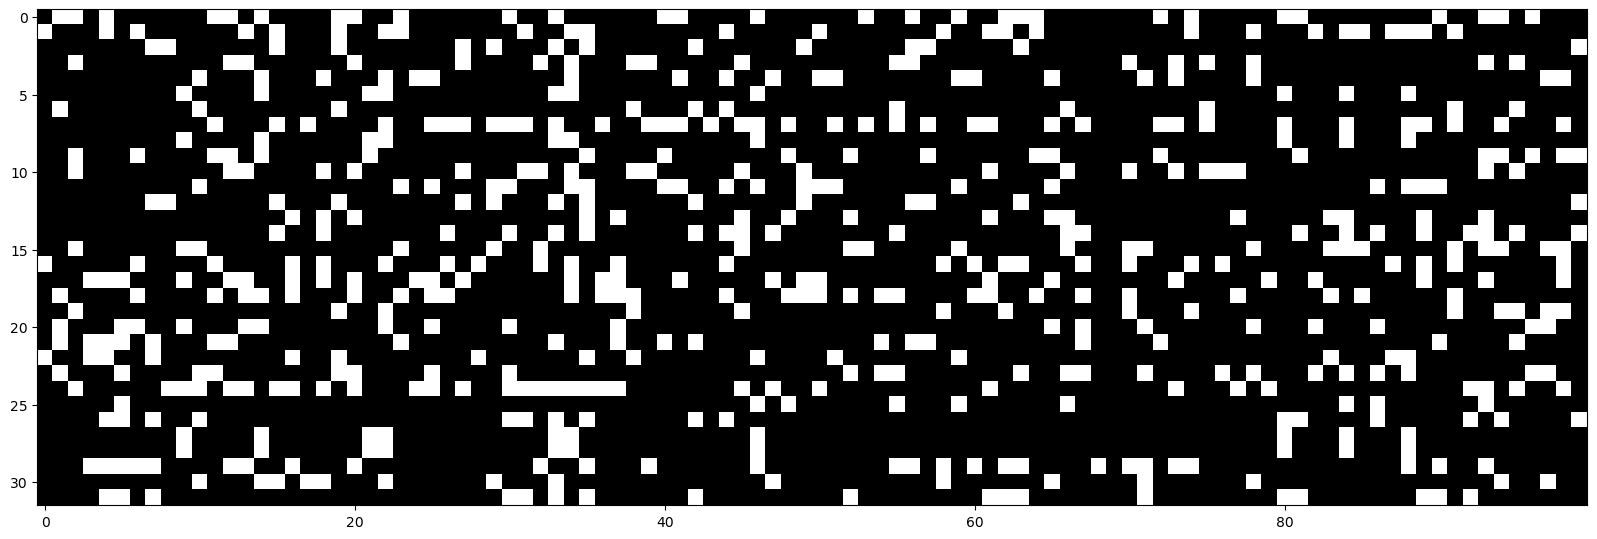

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99  , cmap = 'grey' , interpolation= 'nearest')
# white=True , black=False
# to check if outputs of tanh are saturated

(array([565., 167., 100.,  76.,  82.,  48.,  65.,  49.,  22.,  50.,  31.,
         30.,  45.,  17.,  30.,  22.,  23.,  28.,  28.,  32.,  20.,  15.,
         29.,  24.,  17.,  27.,  24.,  25.,  19.,  20.,  18.,  25.,  16.,
         40.,  19.,  18.,  41.,  27.,  31.,  49.,  49.,  31.,  33.,  36.,
         38.,  75.,  89., 112., 149., 574.]),
 array([-9.99984264e-01, -9.59984587e-01, -9.19984910e-01, -8.79985234e-01,
        -8.39985557e-01, -7.99985880e-01, -7.59986203e-01, -7.19986526e-01,
        -6.79986849e-01, -6.39987172e-01, -5.99987495e-01, -5.59987818e-01,
        -5.19988141e-01, -4.79988464e-01, -4.39988787e-01, -3.99989110e-01,
        -3.59989433e-01, -3.19989756e-01, -2.79990079e-01, -2.39990402e-01,
        -1.99990726e-01, -1.59991049e-01, -1.19991372e-01, -7.99916947e-02,
        -3.99920177e-02,  7.65919685e-06,  4.00073361e-02,  8.00070131e-02,
         1.20006690e-01,  1.60006367e-01,  2.00006044e-01,  2.40005721e-01,
         2.80005398e-01,  3.20005075e-01,  3.60004

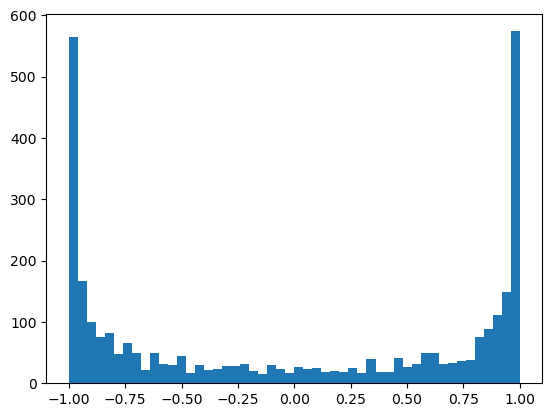

In [9]:
plt.hist(h.view(-1).tolist() , 50)  #if values on -1/1 this will cause 1-t^2 to be 0 , -> reslting in no change in gradient

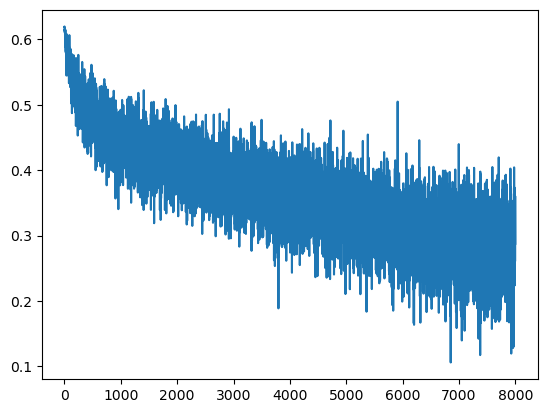

In [10]:
plt.plot(lossi)

In [11]:
split_loss('train')
split_loss('cv')
# currently the model is over fitted

train loss: 1.7428
cv loss: 3.2403


3.240291118621826

In [12]:
# now generating 10 names
g = torch.Generator().manual_seed(21711836)
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 # + b1
        hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(out))

STERTI.BOGA.NH 
GANNO 
IARK.O.O.AMPSH 
HQLPH 
GOLLU 
ROBLArOBAREN 
DsCO 
SENE 
ThE. 
VAUMEENS 
